### Install modules

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


### Import modules

In [24]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import patches
from pycocotools.coco import COCO
from PIL import Image

### Custom functions

In [40]:
def img_w_bbox(img_info:pd.Series, linewidth=5, edgecolor='r', facecolor='none'):
    img_info
    img = Image.open(os.path.join(path_dataset, img_info.img_id))
    
    fig, ax = plt.subplots(figsize=(18, 18))

    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((img_info.x1, img_info.y1),
                             img_info.width, 
                             img_info.height, 
                             linewidth=linewidth, 
                             edgecolor=edgecolor,
                             facecolor=facecolor)

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

### Load data & rearange

In [3]:
path_smp_subm = '/opt/ml/detection/sample_submission/' # common path for sample submission diretory
path_dataset = '/opt/ml/detection/dataset/' # common path for dataset directory

with open(os.path.join(path_dataset, 'train.json'), 'r') as outfile:
    gt_json = (json.load(outfile))

GT_JSON = os.path.join(path_dataset, 'train.json')
with open(GT_JSON, 'r') as outfile:
    test_anno = (json.load(outfile))

train_smp_df = pd.read_csv(os.path.join(path_smp_subm, 'train_sample.csv'))
gt_json.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [4]:
# Check annotation format
gt_json['annotations'][0]

{'image_id': 0,
 'category_id': 0,
 'area': 257301.66,
 'bbox': [197.6, 193.7, 547.8, 469.7],
 'iscrowd': 0,
 'id': 0}

In [5]:
coco = COCO(os.path.join(path_dataset, 'train.json'))

gt_list = []

for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
        
    file_name = image_info['file_name']
        
    for annotation in annotation_info_list:
        gt_list.append([file_name, annotation['category_id'],
                       float(annotation['bbox'][0]),
                       float(annotation['bbox'][0]) + float(annotation['bbox'][2]),
                       float(annotation['bbox'][1]),
                       (float(annotation['bbox'][1]) + float(annotation['bbox'][3]))])


loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [6]:
# Check gt_list informations
gt_list[:10]

[['train/0000.jpg', 0, 197.6, 745.4, 193.7, 663.4],
 ['train/0001.jpg', 3, 0.0, 57.6, 407.4, 588.0],
 ['train/0001.jpg', 7, 0.0, 144.6, 455.6, 637.2],
 ['train/0001.jpg', 4, 722.3, 996.5999999999999, 313.4, 565.3],
 ['train/0001.jpg', 5, 353.2, 586.9, 671.0, 774.4],
 ['train/0001.jpg', 5, 3.7, 781.9000000000001, 448.5, 690.5],
 ['train/0001.jpg', 0, 425.3, 641.7, 681.9, 861.7],
 ['train/0001.jpg', 7, 92.4, 231.6, 601.7, 654.8000000000001],
 ['train/0001.jpg', 0, 622.4, 695.1999999999999, 686.5, 780.7],
 ['train/0002.jpg', 3, 267.9, 899.5, 165.2, 678.2]]

In [7]:
gt_df = pd.DataFrame(gt_list, columns=['img_id', 'label', 'x1', 'x2', 'y1', 'y2'])

In [8]:
# Get box size
gt_df['area'] = gt_df.apply(lambda x: (x['y2']-x['y1'])*(x['x2']-x['x1']), axis=1)

# Get box center point
gt_df['cent_x'] = (gt_df.x2+gt_df.x1)/2
gt_df['cent_y'] = (gt_df.y2+gt_df.y1)/2

# Get width and height
gt_df['width'] = gt_df.x2-gt_df.x1
gt_df['height'] = gt_df.y2-gt_df.y1

# Get label nm
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
map_label_2_nm = {idx: nm for idx, nm in zip(range(len(LABEL_NAME)), LABEL_NAME)}
gt_df['label_nm'] = gt_df.label.map(map_label_2_nm)
gt_df

img_id  label     x1     x2     y1     y2       area  cent_x  \
0      train/0000.jpg      0  197.6  745.4  193.7  663.4  257301.66  471.50   
1      train/0001.jpg      3    0.0   57.6  407.4  588.0   10402.56   28.80   
2      train/0001.jpg      7    0.0  144.6  455.6  637.2   26259.36   72.30   
3      train/0001.jpg      4  722.3  996.6  313.4  565.3   69096.17  859.45   
4      train/0001.jpg      5  353.2  586.9  671.0  774.4   24164.58  470.05   
...               ...    ...    ...    ...    ...    ...        ...     ...   
23139  train/4882.jpg      5    0.0  944.1  116.2  930.3  768591.81  472.05   
23140  train/4882.jpg      7  302.1  567.3  439.3  655.4   57309.72  434.70   
23141  train/4882.jpg      0  511.3  570.0  451.1  481.3    1772.74  540.65   
23142  train/4882.jpg      1  255.0  526.7  421.4  616.5   53008.67  390.85   
23143  train/4882.jpg      1  145.4  565.6  295.4  651.5  149633.22  355.50   

       cent_y  width  height       label_nm  
0      428.55  547.8   469.7  General trash  
1      497.70   57.6   180.6          Metal  
2      546.40  144.6   181.6    Plastic bag  
3      439.35  274.3   251.9          Glass  
4      722.70  233.7   103.4        Plastic  
...       ...    ...     ...            ...  
23139  523.25  944.1   814.1        Plastic  
23140  547.35  265.2   216.1    Plastic bag  
23141  466.20   58.7    30.2  General trash  
23142  518.95  271.7   195.1          Paper  
23143  473.45  420.2   356.1          Paper  

[23144 rows x 12 columns]

### Set figure style

In [9]:
def set_plt_font():
    SMALL_SIZE = 15
    MEDIUM_SIZE = 20 
    BIGGER_SIZE = 25 

    plt.rc('font', size=SMALL_SIZE) # controls default text sizes 
    plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title 
    plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels 
    plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels 
    plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels 
    plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize 
    plt.rc('figure', titlesize=MEDIUM_SIZE)
    
set_plt_font()

### Analyze distribution

Simple distribution of box per img 
count    4883.000000
mean        4.739709
std         6.355155
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max        71.000000
Name: img_id, dtype: float64


/opt/conda/envs/detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


train/0000.jpg     1
train/4336.jpg     1
train/4335.jpg     1
train/0578.jpg     1
train/0580.jpg     1
                  ..
train/2981.jpg    46
train/0394.jpg    48
train/4047.jpg    52
train/0946.jpg    55
train/4197.jpg    71
Name: img_id, Length: 4883, dtype: int64

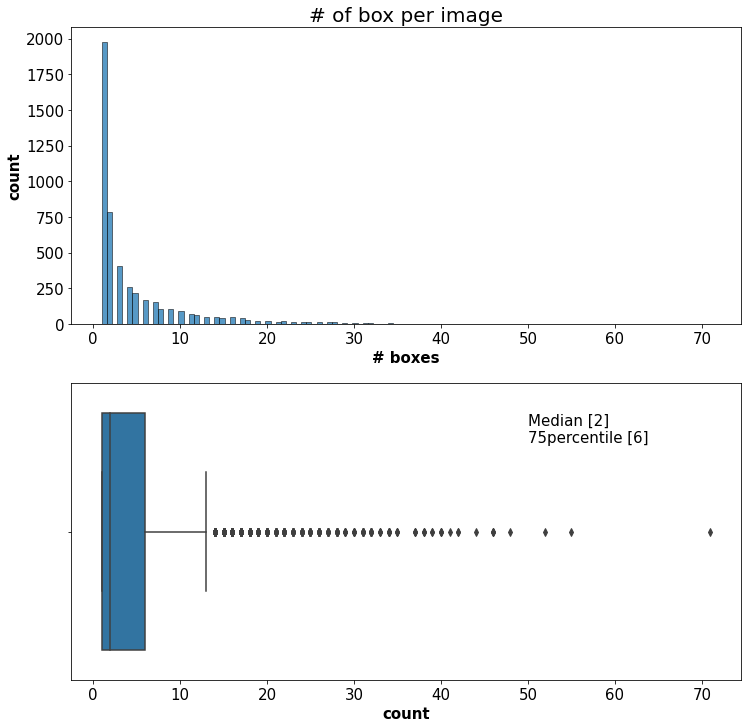

In [10]:
# plot - box per image
fig_box_per_img, ax_box_per_img = plt.subplots(2, 1, figsize=(12, 12))

sns.histplot(gt_df.img_id.value_counts(), ax=ax_box_per_img[0])
sns.boxplot(gt_df.img_id.value_counts(), ax=ax_box_per_img[1], orient='h')

ax_box_per_img[0].set_title('# of box per image', fontsize=20)

ax_box_per_img[0].set_xlabel('# boxes', weight='bold', fontsize=15)
ax_box_per_img[0].set_ylabel('count', weight='bold', fontsize=15)
ax_box_per_img[1].set_xlabel('count', weight='bold', fontsize=15)
ax_box_per_img[1].text(x=50, y=-0.3, s=f'Median [{2}] \n75percentile [{6}]', fontsize=15)

print(f'Simple distribution of box per img \n{gt_df.img_id.value_counts().describe()}')
gt_df.img_id.value_counts().sort_values()

### Sampling top 3 images which have the biggest number of boxes per image

### **Image # 4179 (Top 1)**
![4179.jpg](attachment:2e5a3913-bc5b-4c0a-885f-1a3
c0c89c59b.jpg)

In [11]:
gt_df[gt_df.img_id=='train/4197.jpg']

img_id  label     x1     x2     y1     y2      area  cent_x  \
19857  train/4197.jpg      5   11.5   63.3  567.6  610.3   2211.86   37.40   
19858  train/4197.jpg      1    0.0   25.1  574.0  616.4   1064.24   12.55   
19859  train/4197.jpg      0   80.3  117.5  583.6  595.5    442.68   98.90   
19860  train/4197.jpg      0   11.2   83.7  605.7  636.7   2247.50   47.45   
19861  train/4197.jpg      4   57.6  130.4  597.8  625.7   2031.12   94.00   
...               ...    ...    ...    ...    ...    ...       ...     ...   
19923  train/4197.jpg      0  228.6  268.6  368.0  408.9   1636.00  248.60   
19924  train/4197.jpg      0  220.1  396.2  346.9  409.6  11041.47  308.15   
19925  train/4197.jpg      0  365.0  413.1  386.8  403.1    784.03  389.05   
19926  train/4197.jpg      5  307.8  363.7  358.9  394.5   1990.04  335.75   
19927  train/4197.jpg      0  284.4  322.7  372.6  390.6    689.40  303.55   

       cent_y  width  height       label_nm  
19857  588.95   51.8    42.7        Plastic  
19858  595.20   25.1    42.4          Paper  
19859  589.55   37.2    11.9  General trash  
19860  621.20   72.5    31.0  General trash  
19861  611.75   72.8    27.9          Glass  
...       ...    ...     ...            ...  
19923  388.45   40.0    40.9  General trash  
19924  378.25  176.1    62.7  General trash  
19925  394.95   48.1    16.3  General trash  
19926  376.70   55.9    35.6        Plastic  
19927  381.60   38.3    18.0  General trash  

[71 rows x 12 columns]

### **Image # 0946 (Top 2)**
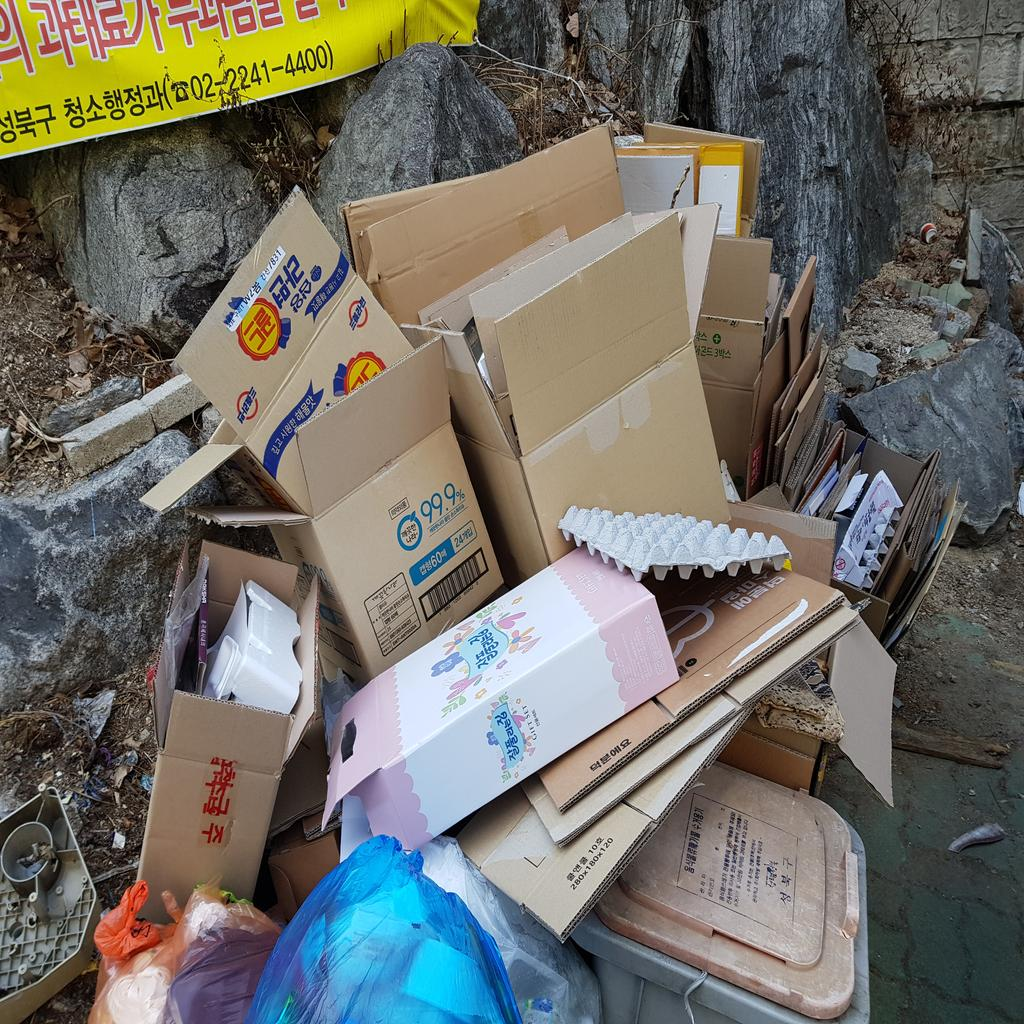

In [12]:
gt_df[gt_df.img_id=='train/0946.jpg']

img_id  label     x1     x2     y1      y2       area  cent_x  \
4515  train/0946.jpg      5    0.0  103.6  783.2  1023.6   24905.44   51.80   
4516  train/0946.jpg      1  267.4  341.3  817.8   923.8    7833.40  304.35   
4517  train/0946.jpg      1  302.0  342.6  798.8   840.1    1676.78  322.30   
4518  train/0946.jpg      1  267.2  356.1  589.9   839.1   22153.88  311.65   
4519  train/0946.jpg      1  319.5  364.5  667.4   760.5    4189.50  342.00   
4520  train/0946.jpg      1  184.4  503.6  353.2   685.4  106038.24  344.00   
4521  train/0946.jpg      1  134.9  320.0  538.4   924.8   71522.64  227.45   
4522  train/0946.jpg      7   86.9  281.9  872.6  1023.6   29445.00  184.40   
4523  train/0946.jpg      7   94.0  161.0  879.4   961.7    5514.10  127.50   
4524  train/0946.jpg      7  417.5  603.9  832.3  1023.6   35658.32  510.70   
4525  train/0946.jpg      1  643.3  764.7  121.2   237.0   14058.12  704.00   
4526  train/0946.jpg      1  615.9  744.4  141.5   236.3   12181.80  680.15   
4527  train/0946.jpg      1  694.3  786.2  234.3   500.8   24491.35  740.25   
4528  train/0946.jpg      1  720.0  741.1  458.8   502.1     913.63  730.55   
4529  train/0946.jpg      1  778.7  816.5  254.3   379.9    4747.68  797.60   
4530  train/0946.jpg      1  743.9  789.6  324.7   501.1    8061.48  766.75   
4531  train/0946.jpg      1  804.1  948.6  417.2   637.3   31804.45  876.35   
4532  train/0946.jpg      1  763.4  824.1  322.7   487.9   10027.64  793.75   
4533  train/0946.jpg      1  773.3  829.4  347.1   493.7    8224.26  801.35   
4534  train/0946.jpg      1  783.5  828.2  394.8   512.3    5252.25  805.85   
4535  train/0946.jpg      1  813.2  846.5  417.5   466.9    1645.02  829.85   
4536  train/0946.jpg      1  801.0  846.2  427.3   499.4    3258.92  823.60   
4537  train/0946.jpg      1  797.2  869.1  431.1   516.8    6161.83  833.15   
4538  train/0946.jpg      1  817.8  861.2  451.7   519.8    2955.54  839.50   
4539  train/0946.jpg      1  831.0  870.9  469.3   560.7    3646.86  850.95   
4540  train/0946.jpg      1  831.5  903.4  469.3   586.1    8397.92  867.45   
4541  train/0946.jpg      1  883.8  968.9  499.8   653.5   13079.87  926.35   
4542  train/0946.jpg      1  877.2  961.0  476.4   646.4   14246.00  919.10   
4543  train/0946.jpg      1  918.9  943.8  488.0   564.5    1904.85  931.35   
4544  train/0946.jpg      1  886.6  934.3  500.8   620.0    5685.84  910.45   
4545  train/0946.jpg      1  873.7  937.7  473.7   605.4    8428.80  905.70   
4546  train/0946.jpg      1  868.1  941.5  448.3   596.6   10885.22  904.80   
4547  train/0946.jpg      1  857.4  900.6  509.6   589.9    3468.96  879.00   
4548  train/0946.jpg      1  858.7  894.8  506.9   576.7    2519.78  876.75   
4549  train/0946.jpg      1  338.3  503.4  167.6   285.8   19514.82  420.85   
4550  train/0946.jpg      1  355.0  625.5  120.6   328.2   56155.80  490.25   
4551  train/0946.jpg      1  399.5  727.4  202.2   587.2  126241.50  563.45   
4552  train/0946.jpg      1  421.1  676.6  211.0   456.5   62725.25  548.85   
4553  train/0946.jpg      1  461.0  496.3  315.6   399.2    2951.08  478.65   
4554  train/0946.jpg      1  746.2  792.7  481.9   511.4    1371.75  769.45   
4555  train/0946.jpg      1  711.6  897.0  498.5   811.4   58011.66  804.30   
4556  train/0946.jpg      1  740.3  829.2  657.3   802.2   12881.61  784.75   
4557  train/0946.jpg      9  754.5  872.1  597.0   745.7   17487.12  813.30   
4558  train/0946.jpg      1  453.8  767.7  691.8   944.1   79196.97  610.75   
4559  train/0946.jpg      1  519.9  861.7  603.8   847.6   83330.84  690.80   
4560  train/0946.jpg      1  536.4  846.0  561.1   814.4   78421.68  691.20   
4561  train/0946.jpg      1  320.8  679.9  541.8   862.1  115019.73  500.35   
4562  train/0946.jpg      1  137.9  414.7  185.6   517.5   91869.92  276.30   
4563  train/0946.jpg      0  557.2  792.4  505.2   581.4   17922.24  674.80   
4564  train/0946.jpg      6  227.8  303.2  579.0   713.4   10133

### **Image # 4047 (Top 3)**
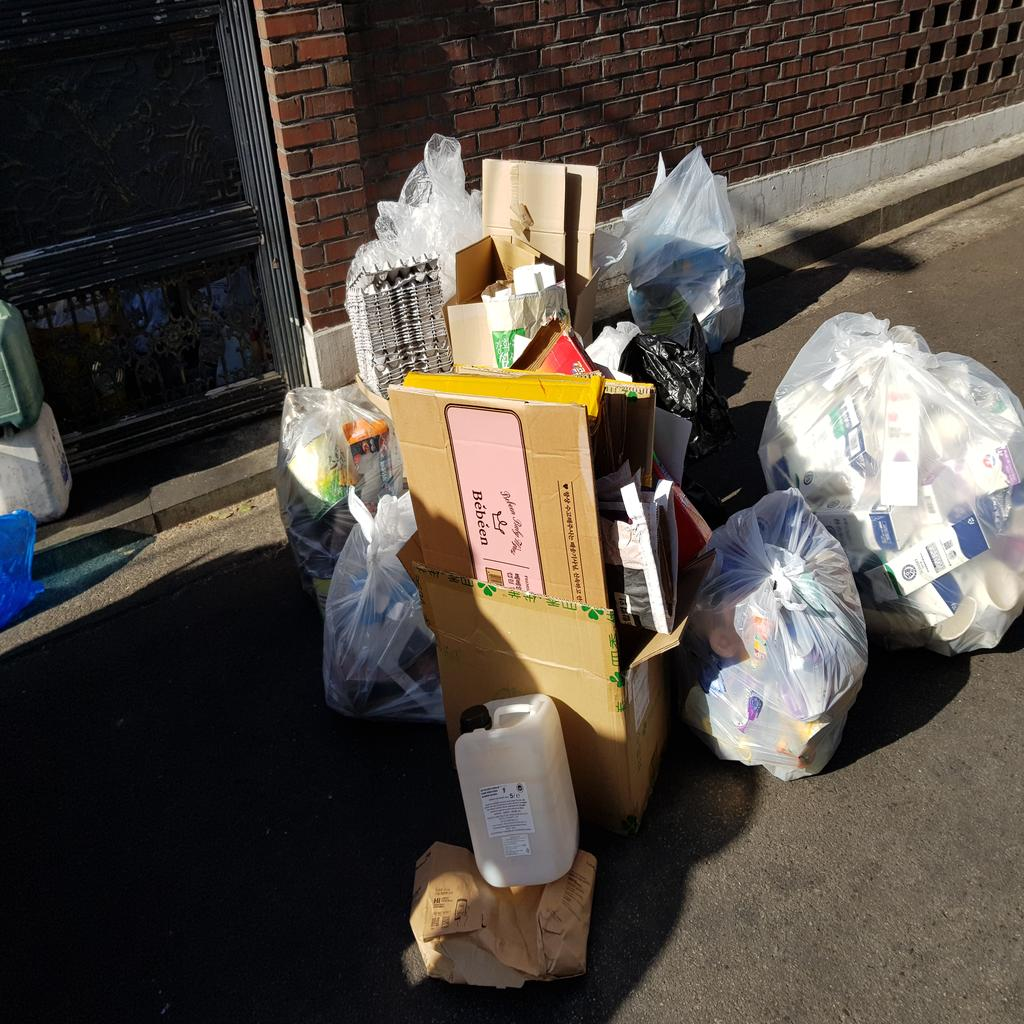

In [13]:
gt_df[gt_df.img_id=='train/4047.jpg']

img_id  label     x1      x2     y1     y2      area  cent_x  \
19144  train/4047.jpg      7  592.5   622.2  229.2  278.6   1467.18  607.35   
19145  train/4047.jpg      1  408.9   597.1  841.1  988.7  27778.32  503.00   
19146  train/4047.jpg      7  275.3   407.9  381.6  626.4  32460.48  341.60   
19147  train/4047.jpg      7  322.0   446.2  484.6  724.0  29733.48  384.10   
19148  train/4047.jpg      1  353.8   394.2  371.8  422.6   2052.32  374.00   
19149  train/4047.jpg      5    0.0    71.9  401.6  526.2   8958.74   35.95   
19150  train/4047.jpg      7  757.3  1023.7  311.2  656.6  92014.56  890.50   
19151  train/4047.jpg      7  674.0   868.0  486.3  781.9  57346.40  771.00   
19152  train/4047.jpg      1  651.4   712.9  451.4  567.9   7164.75  682.15   
19153  train/4047.jpg      7  344.1   481.8  133.1  315.6  25130.25  412.95   
19154  train/4047.jpg      1  508.2   598.4  158.8  274.9  10472.22  553.30   
19155  train/4047.jpg      1  482.0   566.8  158.1  268.8   9387.36  524.40   
19156  train/4047.jpg      1  441.1   600.1  234.0  369.1  21480.90  520.60   
19157  train/4047.jpg      0  480.8   583.7  277.0  368.8   9446.22  532.25   
19158  train/4047.jpg      1  507.2   597.9  317.0  375.6   5315.02  552.55   
19159  train/4047.jpg      7  584.1   641.2  320.7  370.5   2843.58  612.65   
19160  train/4047.jpg      1  359.1   404.3  374.2  396.9   1026.04  381.70   
19161  train/4047.jpg      1  358.9   452.6  358.3  387.1   2698.56  405.75   
19162  train/4047.jpg      1  358.1   452.3  352.2  385.4   3127.44  405.20   
19163  train/4047.jpg      1  357.8   450.8  350.1  382.6   3022.50  404.30   
19164  train/4047.jpg      1  356.6   450.3  348.1  378.9   2885.96  403.45   
19165  train/4047.jpg      1  356.1   449.8  342.7  370.8   2632.97  402.95   
19166  train/4047.jpg      1  355.6   448.3  334.6  363.0   2632.68  401.95   
19167  train/4047.jpg      1  355.0   446.9  332.9  356.6   2178.03  400.95   
19168  train/4047.jpg      1  354.3   445.7  325.1  345.4   1855.42  400.00   
19169  train/4047.jpg      1  353.5   444.7  323.0  342.3   1760.16  399.10   
19170  train/4047.jpg      1  352.5   443.9  320.3  339.9   1791.44  398.20   
19171  train/4047.jpg      1  352.0   443.4  317.3  337.6   1855.42  397.70   
19172  train/4047.jpg      1  351.2   442.9  308.1  334.2   2393.37  397.05   
19173  train/4047.jpg      1  350.0   440.9  307.1  329.1   1999.80  395.45   
19174  train/4047.jpg      1  350.0   443.5  300.4  326.5   2440.35  396.75   
19175  train/4047.jpg      1  349.0   443.2  295.3  322.4   2552.82  396.10   
19176  train/4047.jpg      1  348.2   442.2  292.9  318.6   2415.80  395.20   
19177  train/4047.jpg      1  346.9   442.4  289.2  315.3   2492.55  394.65   
19178  train/4047.jpg      1  346.7   440.9  285.8  310.2   2298.48  393.80   
19179  train/4047.jpg      1  346.2   441.7  280.4  305.8   2425.70  393.95   
19180  train/4047.jpg      1  345.4   439.6  274.6  301.0   2486.88  392.50   
19181  train/4047.jpg      1  345.4   439.4  250.6  291.9   3882.20  392.40   
19182  train/4047.jpg      1  345.1   439.8  264.8  298.0   3144.04  392.45   
19183  train/4047.jpg      1  354.3   446.5  328.8  351.1   2056.06  400.40   
19184  train/4047.jpg      7  618.9   745.1  144.3  351.5  26148.64  682.00   
19185  train/4047.jpg      7  617.1   736.0  312.6  531.0  25967.76  676.55   
19186  train/4047.jpg      1  592.8   632.4  362.0  381.6    776.16  612.60   
19187  train/4047.jpg      1  402.8   656.0  363.3  486.9  31295.52  529.40   
19188  train/4047.jpg      1  653.0   692.6  406.7  488.6   3243.24  672.80   
19189  train/4047.jpg      1  512.8   556.2  262.4  294.6   1397.48  534.50   
19190  train/4047.jpg      1  394.7   716.5  531.0  834.4  97634.12  555.60   
19191  train/4047.jpg      1  595.6   678.1  458.2  635.3  14610.75  636.85   
19192  train/4047.jpg      5    0.0    44.2  298.7  430.4   5821.14   22.10   
19193  train/4047.jpg      7    0.0    45.2  509.3  630.5   5478.

/opt/conda/envs/detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count      ratio
label_nm                       
Paper           6352  39.949686
Plastic bag     5178  32.566038
General trash   3966  24.943396
Plastic         2943  18.509434
Styrofoam       1263   7.943396
Glass            982   6.176101
Metal            936   5.886792
Paper pack       897   5.641509
Clothing         468   2.943396
Battery          159   1.000000

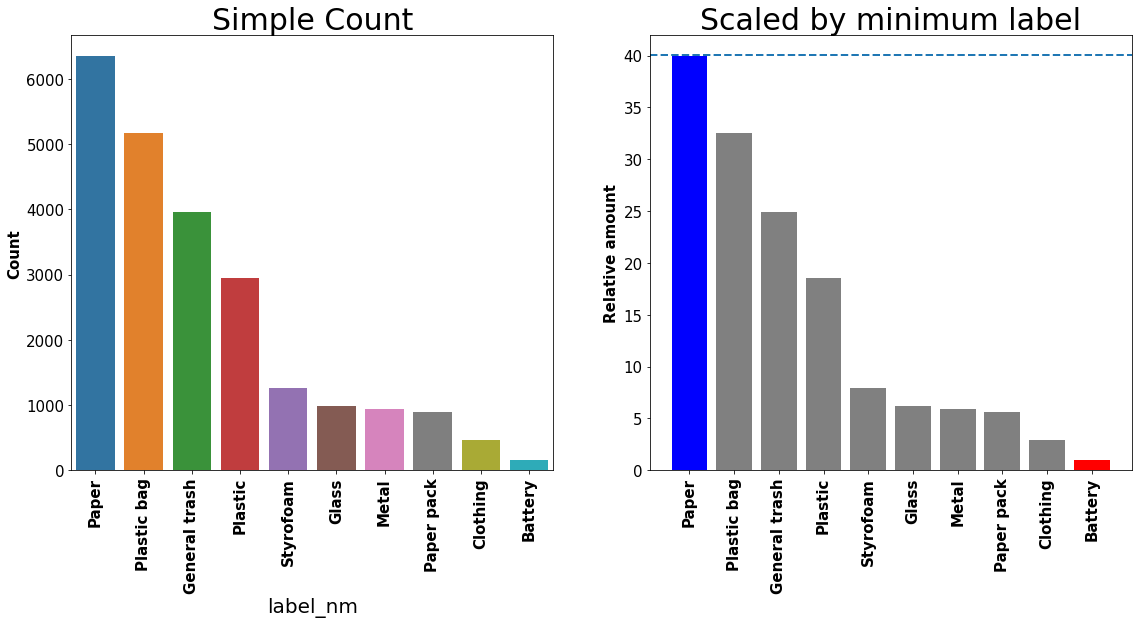

In [14]:
# plot - label imbalance
# sns.countplot(gt_df.label)
# gt_df.label_nm.value_counts().sort_values(ascending=False)

cnt_class = gt_df.label_nm.value_counts().sort_values(ascending=False)
cnt_class_scaled = cnt_class/cnt_class.min()

fig_trg_class, ax_trg_class = plt.subplots(1, 2, figsize=(19, 8))

sns.countplot(gt_df.label_nm, ax=ax_trg_class[0], order=gt_df.label_nm.value_counts().sort_values(ascending=False).index)

ax_trg_class[0].set_title('Simple Count', fontsize=30)
ax_trg_class[0].set_xticklabels(cnt_class.index, rotation=90, weight='bold', fontsize=15)
ax_trg_class[0].set_ylabel('Count', weight='bold', fontsize=15)

ax_trg_class[1].bar(x=cnt_class_scaled.index, height=cnt_class_scaled, color='grey')
ax_trg_class[1].bar(x=cnt_class_scaled.nsmallest(len(cnt_class_scaled)).index[0], height=cnt_class_scaled.nsmallest(len(cnt_class_scaled)).iat[0], color='red')
ax_trg_class[1].bar(x=cnt_class_scaled.nsmallest(len(cnt_class_scaled)).index[-1], height=cnt_class_scaled.nsmallest(len(cnt_class_scaled)).iat[-1], color='blue')
ax_trg_class[1].axhline(cnt_class_scaled.nsmallest(len(cnt_class_scaled)).iat[-1]+0.1, linestyle='--', linewidth=2)

ax_trg_class[1].set_ylabel('Relative amount', weight='bold', fontsize=15)
ax_trg_class[1].set_xticks(np.arange(0, 10))
ax_trg_class[1].set_title('Scaled by minimum label', fontsize=30)
ax_trg_class[1].set_xticklabels(cnt_class.index, rotation=90, weight='bold', fontsize=15)

cnt_class = pd.DataFrame(cnt_class)
cnt_class.index.name='label_nm'
cnt_class.columns=['count']
cnt_class['ratio']=cnt_class.apply(lambda x: x/x.min())
cnt_class

<AxesSubplot:xlabel='y2', ylabel='Count'>

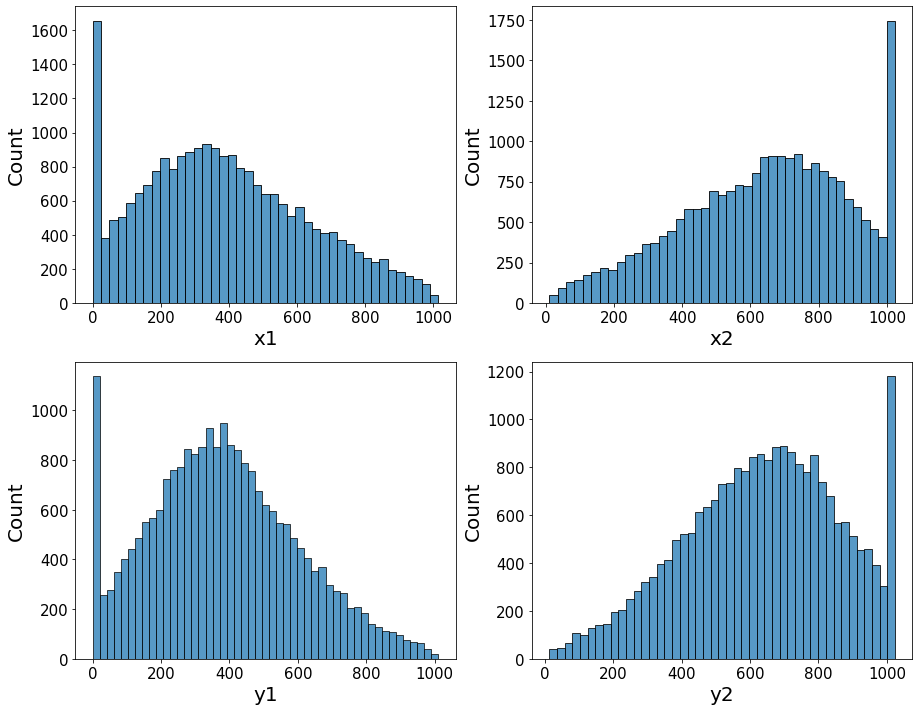

In [15]:
# Plot - distribution of coordinates
fig_corrd, ax_corrd = plt.subplots(2, 2, figsize=(15, 12))

# sns.set(font_scale=1.5)

sns.histplot(gt_df.x1, ax=ax_corrd[0, 0])
sns.histplot(gt_df.x2, ax=ax_corrd[0, 1])
sns.histplot(gt_df.y1, ax=ax_corrd[1, 0])
sns.histplot(gt_df.y2, ax=ax_corrd[1, 1])

### **Observation & Insight**
>bbox의 꼭지점 좌표값인 x1, x2, y1, y2 모두 극단적인 값에서 높은 수치를 보여, 사진을 촬영할 때 피사체를 중심에 둘 것이라는 예상과 벗어나는 결과를 보였음. 이는 실제 bbox를 image.jpg위에 그려 눈으로 확인해봐야 할 것으로 생각됨. 이런 끝값의 높은 수치가 모델 성능에 미칠 영향은 예상하기 어려우나, 데이터 수집 과정에서 예상치 못한 부분이 있을 가능성을 시사함

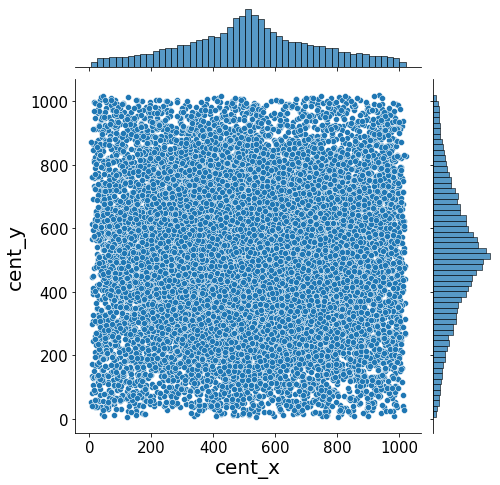

In [16]:
# Plot - center coordinates by jointplot
sns.jointplot(x='cent_x', y='cent_y', data=gt_df, height=7)

### **Observation & Insight**
>bbox의 중심 좌표는 x축과 y축 모두 gaussian distribution의 형태를 보임. 이는 사진을 촬영할 때 피사체를 사진의 중심에 둘 것이라는 직관적인 예상에 부합하는 결과로 볼 수 있음. 다만, x축 y축 모두 양극단에 값들이 존재하는데, 이는 지나치게 작은 형태의 box이거나 width, height 중 하나가 극단적으로 작은 경우일 수 있어 모델의 예측력에 부정적인 영향을 미칠 가능성이 예상됨. 이에 따라 에러 분석에서 오답 샘플링시 연관성을 자세히 살펴야 할 것으로 보임

5159        0.7
6539        1.3
13598       7.1
20511       8.4
1524        8.5
          ...  
10443    1023.8
7810     1023.8
13981    1023.8
4512     1023.9
5565     1023.9
Name: width, Length: 23144, dtype: float64
5159        0.8
6539        2.4
17594       5.3
11349       7.2
5234        7.4
          ...  
20006    1023.8
4272     1023.8
11449    1023.8
5428     1023.8
5565     1023.9
Name: height, Length: 23144, dtype: float64


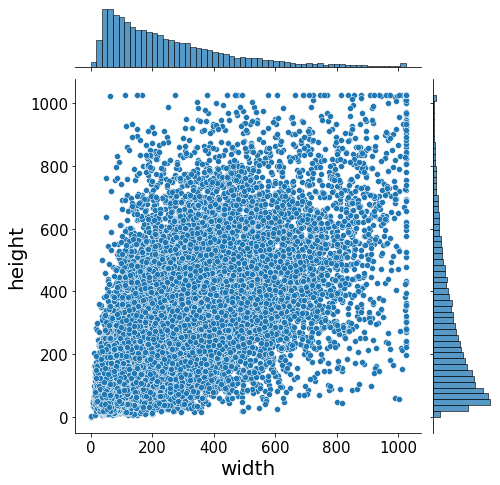

In [17]:
# Plot - width and height by jointplot
sns.jointplot(x='width', y='height', data=gt_df, height=7)
print(gt_df.width.sort_values())
print(gt_df.height.sort_values())

In [53]:
gt_df.sort_values(by='height',ascending=False).iloc[:50]

img_id  label     x1      x2   y1      y2        area  cent_x  \
5565   train/1160.jpg      7    0.0  1023.9  0.0  1023.9  1048371.21  511.95   
5428   train/1126.jpg      1  145.4  1023.1  0.0  1023.8   898589.26  584.25   
20006  train/4220.jpg      0    0.0  1023.7  0.0  1023.8  1048064.06  511.85   
11449  train/2422.jpg      0    0.0  1023.7  0.0  1023.8  1048064.06  511.85   
4272   train/0901.jpg      7    0.0  1023.7  0.0  1023.8  1048064.06  511.85   
10889  train/2302.jpg      7  530.6  1023.6  0.0  1023.7   504684.10  777.10   
4129   train/0868.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
4123   train/0864.jpg      1  644.7  1023.6  0.0  1023.7   387879.93  834.15   
11136  train/2361.jpg      5   62.6  1023.6  0.0  1023.7   983775.70  543.10   
11441  train/2419.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
3985   train/0838.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
358    train/0072.jpg      1  749.0   914.6  0.0  1023.7   169524.72  831.80   
3656   train/0783.jpg      9  417.3  1023.8  0.0  1023.7   620874.05  720.55   
3655   train/0783.jpg      9    0.0   443.9  0.0  1023.7   454420.43  221.95   
12660  train/2668.jpg      9    0.0   723.0  0.0  1023.7   740135.10  361.50   
20318  train/4273.jpg      7  749.2  1023.7  0.0  1023.7   281005.65  886.45   
21841  train/4586.jpg      0  228.9   892.3  0.0  1023.7   679122.58  560.60   
10886  train/2302.jpg      1    0.0   936.6  0.0  1023.7   958797.42  468.30   
10443  train/2194.jpg      0    0.0  1023.8  0.0  1023.7  1048064.06  511.90   
480    train/0108.jpg      7    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
22362  train/4725.jpg      7    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
4605   train/0956.jpg      1  156.1   901.8  0.0  1023.7   763373.09  528.95   
9777   train/2040.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
9759   train/2039.jpg      5   11.5  1023.6  0.0  1023.7  1036086.77  517.55   
4675   train/0973.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
9492   train/1991.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
8832   train/1861.jpg      0    0.0   907.4  0.0  1023.7   928905.38  453.70   
5064   train/1056.jpg      7    0.0   692.8  0.0  1023.7   709219.36  346.40   
7980   train/1687.jpg      7    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
7907   train/1677.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
7904   train/1677.jpg      7    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
7810   train/1667.jpg      0    0.0  1023.8  0.0  1023.7  1048064.06  511.90   
7315   train/1545.jpg      7  329.5  1018.6  0.0  1023.7   705431.67  674.05   
13337  train/2841.jpg      0    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
14230  train/3007.jpg      7    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
7124   train/1498.jpg      0  294.6   406.6  0.0  1023.7   114654.40  350.60   
13835  train/2948.jpg      0    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
20301  train/4269.jpg      0    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
20386  train/4284.jpg      0  434.5   585.4  0.0  1023.7   154476.33  509.95   
950    train/0186.jpg      7    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
966    train/0190.jpg      5    0.0  1021.7  0.0  1023.7  1045914.29  510.85   
19951  train/4208.jpg      0  187.9  1023.6  0.0  1023.7   855506.09  605.75   
1073   train/0220.jpg      5    2.8   860.2  0.0  1023.7   877720.38  431.50   
19324  train/4075.jpg      1    0.0  1000.9  0.0  1023.7  1024621.33  500.45   
19106  train/4041.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
19104  train/4041.jpg      1    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
18918  train/3988.jpg      0  553.3  1023.6  0.0  1023.7   481446.11  788.45   
789    train/0165.jpg      0    0.0  1023.7  0.0  1023.7  1047961.69  511.85   
18640  train/3926.jpg      7  137.1   845.4  0.0  1023.7   725086.71  491.25   
18283  train/38

### **Observation & Insight**
> Width, height 모두 작은 값에 편향되어 있음. 이미지 크기에 비해 대부분의 bbox가 상당히 작은 것으로 보임. 특히, 0에 가까운 width, height도 관찰되는데, 이는 모델이 예측하기 어려울 것으로 예상됨. 또, 극단적으로 큰 크기를 보이는 bbox도 관찰되며, width, height 둘 중 하나의 값이 다른 하나에 비해 지나치게 큰 경우도 관찰됨

### Width, Height가 모두 극단적으로 작은 box가 존재하는 sample image
<!-- 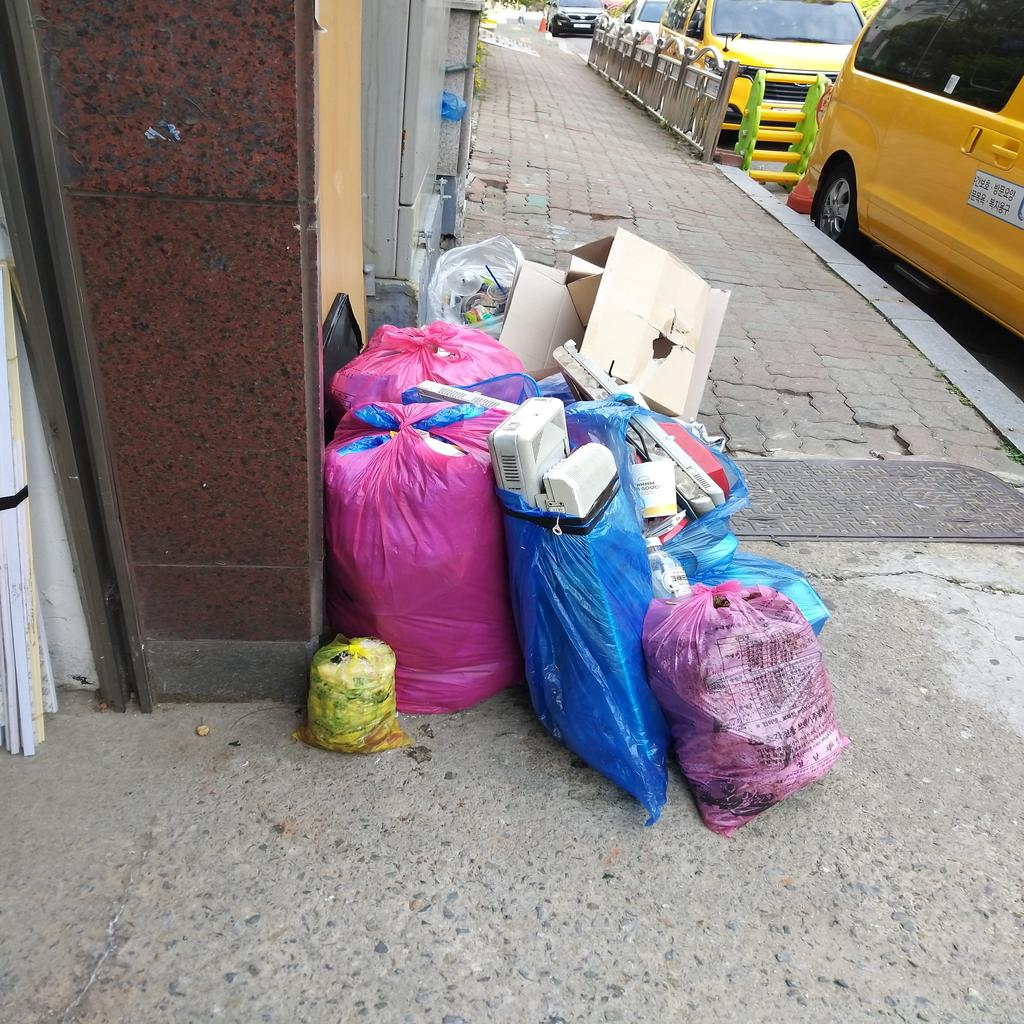 -->
bbox가 너무 작아 육안으로 확인이 되지 않으며 bbox를 그리는 것도 쉽지 않음

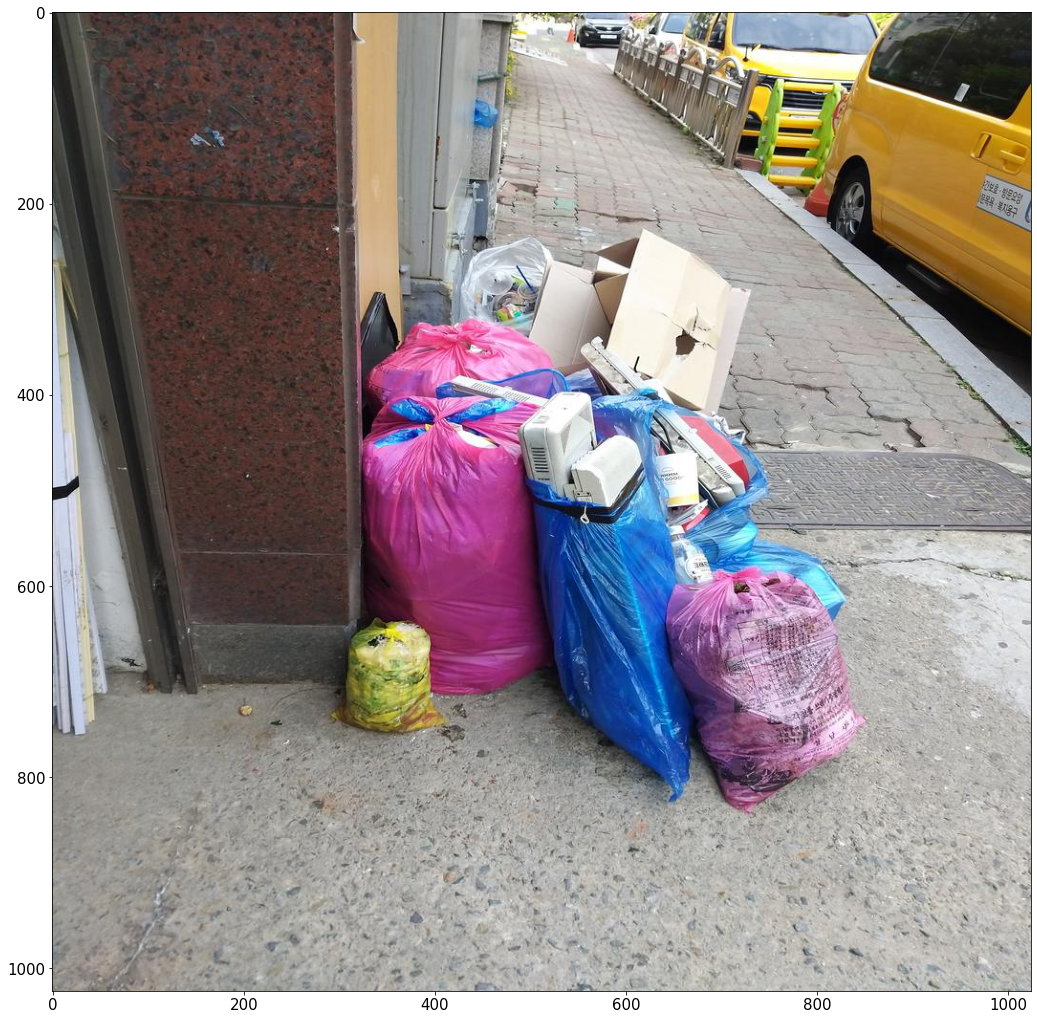

img_id      train/1063.jpg
label                    0
x1                   647.8
x2                   648.5
y1                   460.2
y2                   461.0
area                  0.56
cent_x              648.15
cent_y               460.6
width                  0.7
height                 0.8
label_nm     General trash
Name: 5159, dtype: object

In [44]:
img_w_bbox(gt_df.loc[5159, :], linewidth=10, edgecolor='purple', facecolor='purple')
gt_df.loc[5159, :]

### Width, Height가 모두 극단적으로 큰 box가 존재하는 sample image
화면 전체를 Plastic bag 처리한 것을 확인할 수 있음
<!-- 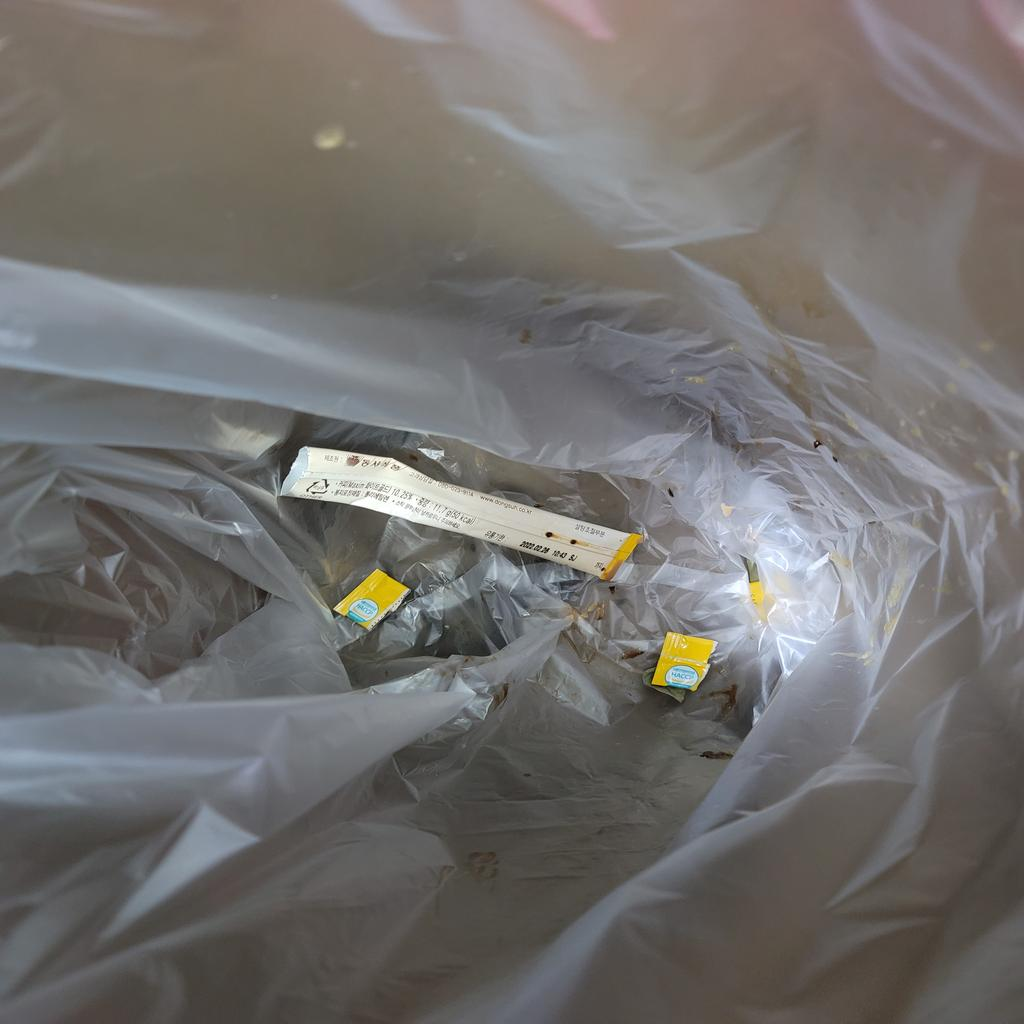 -->

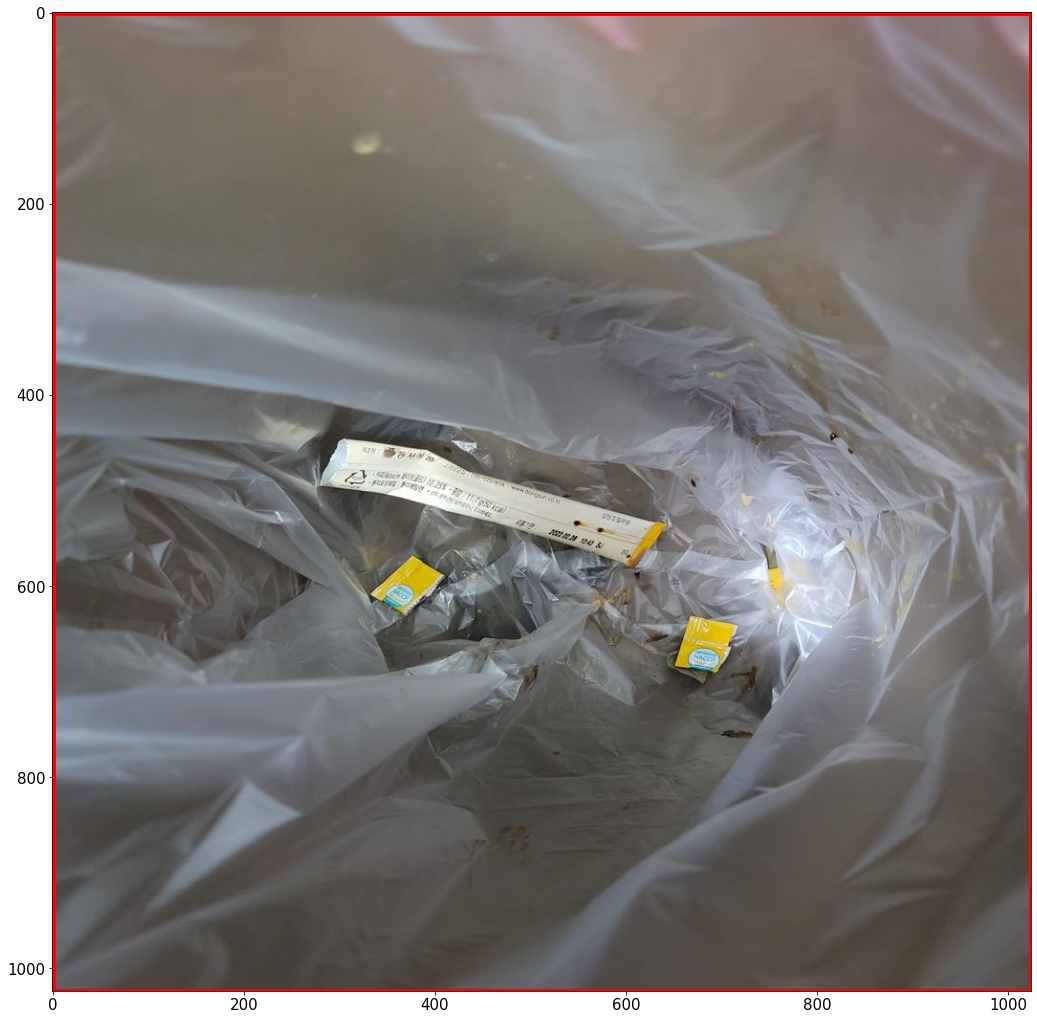

In [45]:
img_w_bbox(gt_df.loc[5565, :])

### Width, Height의 차이가 상대적으로 큰 경우
해당 경우는 문제가 된다고 보기 어려운 사례로 판단됨

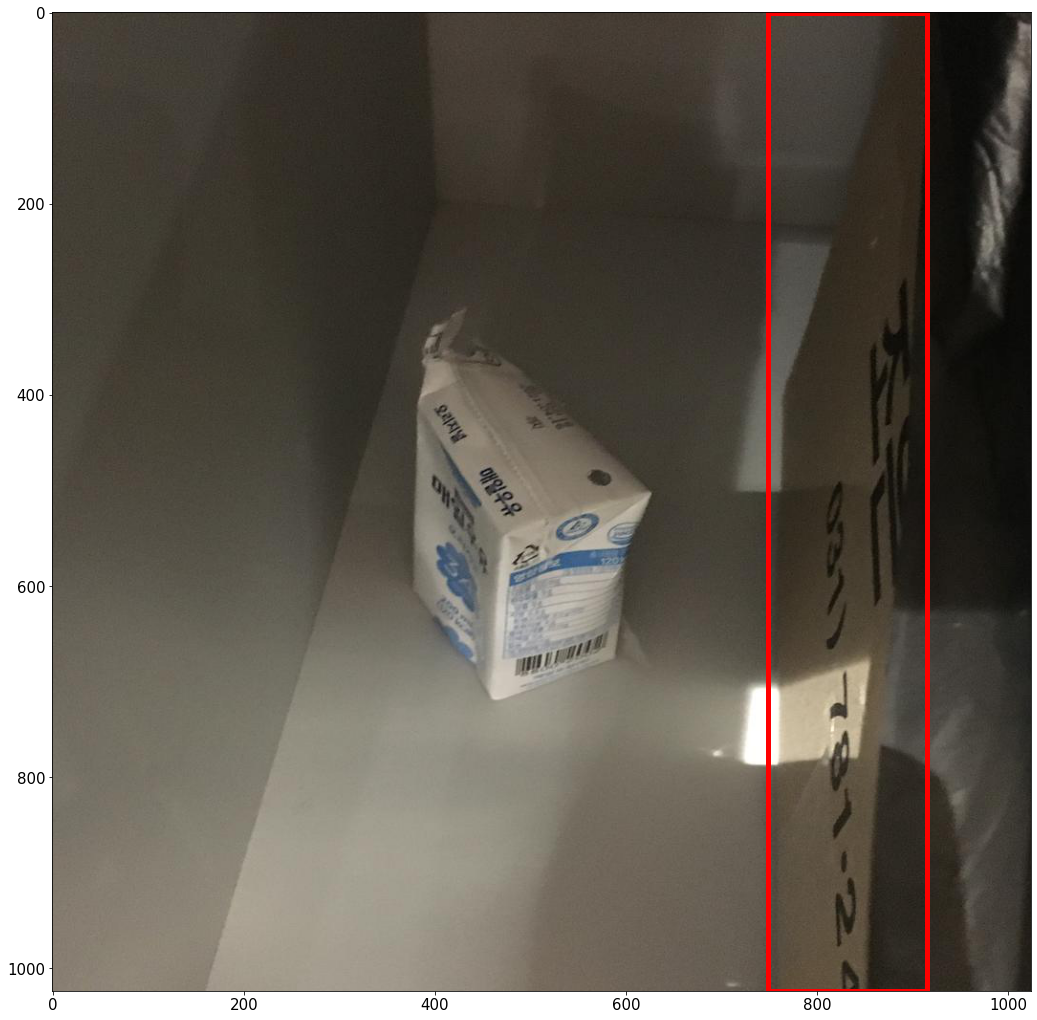

img_id      train/0072.jpg
label                    1
x1                   749.0
x2                   914.6
y1                     0.0
y2                  1023.7
area             169524.72
cent_x               831.8
cent_y              511.85
width                165.6
height              1023.7
label_nm             Paper
Name: 358, dtype: object

In [58]:
img_w_bbox(gt_df.loc[358, :])
gt_df.loc[358, :]